In [163]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kneed import KneeLocator
from scipy.ndimage import gaussian_filter

from biobank_olink.constants import PROJECT_DATA, PROJECT_ROOT

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dump future importances to the Excel spreadsheet

In [164]:
rank_col = "importance_rank"
value_col = "importance_value"


def get_feature_importances(filename: str):
    df = pd.read_json(PROJECT_ROOT / "results" / filename)
    feat_imps = pd.DataFrame.from_records(df.shap_importance).T.assign(**{
        rank_col: lambda df_: df_.rank(ascending=False).mean(axis=1),
        value_col: lambda df_: df_.mean(axis=1),
    })[[rank_col, value_col]].sort_values(by=rank_col).reset_index(names=["feature"])
    study_name = filename.replace("xgb_corr0.9_", "").replace(".json", "")
    feat_imps.columns = pd.MultiIndex.from_product([[study_name], feat_imps.columns])
    return feat_imps


file_names = [
    "cross_sectional_xgb_corr0.9_lifestyle_ext_olink.json",
    "cross_sectional_xgb_corr0.9_immune_infla2_lifestyle_ext_olink.json",
    "prospective_xgb_corr0.9_y10_lifestyle_ext_olink.json",
    "prospective_xgb_corr0.9_immune_infla2_y10_lifestyle_ext_olink.json",
    "cross_sectional_adj_xgb_corr0.9_sbp_th0.35.json",
    "cross_sectional_adj_xgb_corr0.9_immune_infla2_sbp_th0.35.json",
]

df = pd.concat([get_feature_importances(fn) for fn in file_names], axis=1)
df

cross_sectional_lifestyle_ext_olink                                   \
                                 feature importance_rank importance_value   
0                                    REN             1.4      1313.225541   
1                                    age             1.6      1265.738082   
2                                  ACTA2             3.4       560.455918   
3                                  PTPRB             3.6       538.746556   
4                       GlucoseInstance0             6.2       433.196165   
...                                  ...             ...              ...   
2745                         alcohol_2.0          2685.8       447.633333   
2746                              GLIPR1          2685.8       447.633333   
2747                         smoking_1.0          2685.8       447.633333   
2748                         alcohol_6.0          2685.8       447.633333   
2749                         alcohol_4.0          2685.8       447.633333   

     cross_sectional_immune_infla2_lifestyle_ext_olink                  \
                                               feature importance_rank   
0                                                  age             1.0   
1                                                LMOD1             2.0   
2                                               HAVCR1             4.2   
3                                     GlucoseInstance0             4.8   
4                                                ERBB2             5.0   
...                                                ...             ...   
2745                                               NaN             NaN   
2746                                               NaN             NaN   
2747                                               NaN             NaN   
2748                                               NaN             NaN   
2749                                               NaN             NaN   

                      prospective_y10_lifestyle_ext_olink                  \
     importance_value                             feature importance_rank   
0         1736.651225                                 age             1.0   
1          781.617381                                 REN             2.2   
2          567.178251                               GDF15             3.0   
3          536.064231                              HAVCR1             4.0   
4          510.835693                                 bmi             6.6   
...               ...                                 ...             ...   
2745              NaN                                XIAP          2639.3   
2746              NaN                         alcohol_2.0          2641.9   
2747              NaN                         alcohol_6.0          2643.8   
2748              NaN                         alcohol_1.0          2646.3   
2749              NaN                              GLIPR1          2646.8   

                      prospective_immune_infla2_y10_lifestyle_ext_olink  \
     importance_value                                           feature   
0          539.043701                                               age   
1          355.456042                                            HAVCR1   
2          295.971893                                               ADM   
3          241.265737                                               bmi   
4          142.346770                                             MMP12   
...               ...                                               ...   
2745       440.091579                                               NaN   
2746       440.563157                                               NaN   
2747       440.717930                                               NaN   
2748       441.072760                                               NaN   
2749       441.133333                                               NaN   

                                      cross_sectional_adj_sbp_

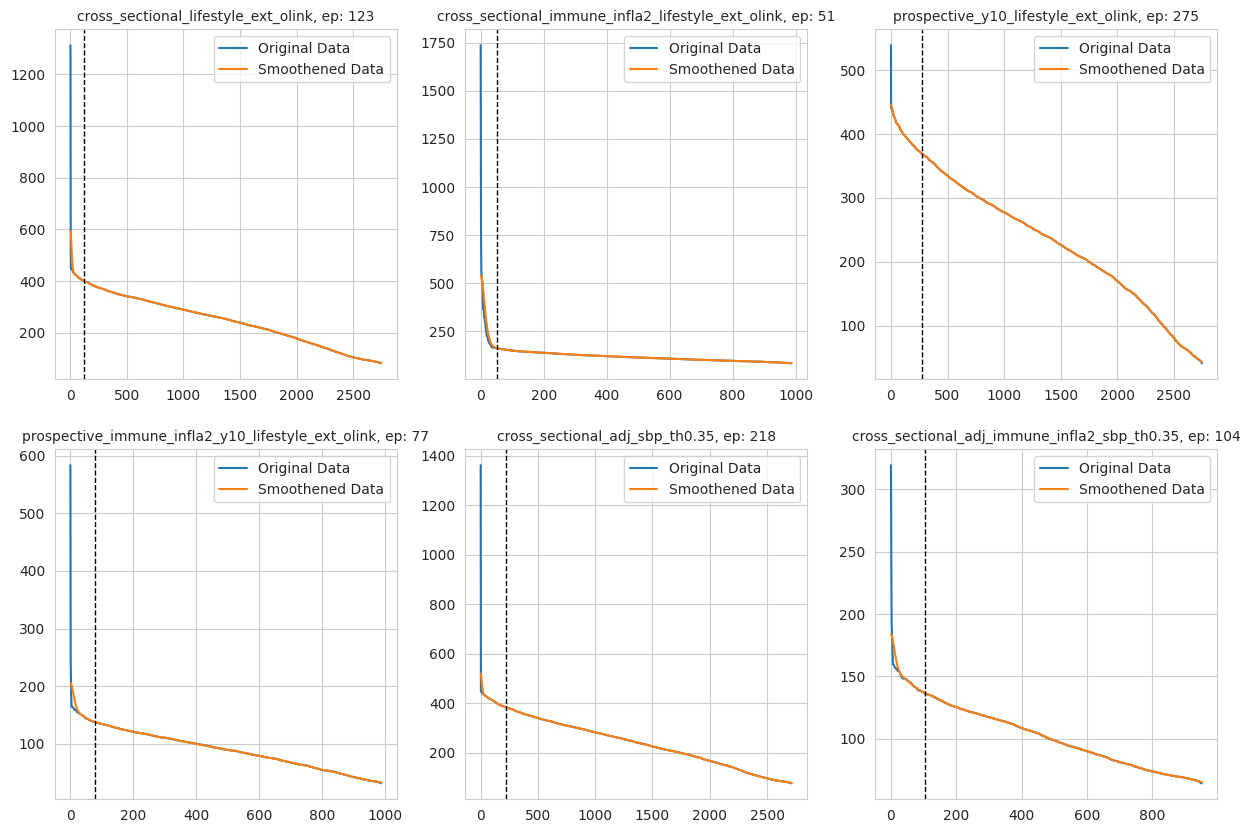

In [165]:
study_names = df.columns.get_level_values(0).unique()
ncols = 3
nrows = int(np.ceil(len(study_names) / ncols))
base_size = 5
plt.figure(figsize=(base_size * ncols, base_size * nrows))

for i, study_name in enumerate(study_names, 1):
    plt.subplot(nrows, ncols, i)

    feat_imps = df[(study_name, value_col)].dropna().sort_values(ascending=False)

    y = feat_imps.values.reshape(-1)
    y_fit = gaussian_filter(y, sigma=10)
    x = np.arange(len(y))

    kneedle = KneeLocator(x, y_fit, curve='convex', direction='decreasing')
    elbow_point = kneedle.elbow
    
    df.loc[elbow_point:, (study_name, slice(None))] = np.nan

    plt.plot(x, y, label='Original Data')
    plt.plot(x, y_fit, label='Smoothened Data')
    plt.axvline(x=elbow_point, color='k', linestyle='--', lw=1)
    plt.title(f"{study_name}, ep: {elbow_point}", fontsize=10)
    plt.legend()
    
df.dropna(how="all", axis=0, inplace=True)

In [167]:
df.to_excel(PROJECT_DATA / "feature_importances.xlsx")